In [1]:
# ======================================
# 📦 0. Install BitsAndBytes (if not already)
# ======================================
!pip install bitsandbytes --quiet
# !pip install transformers datasets scikit-learn matplotlib --quiet

In [1]:
# ======================================
# 1. Imports (add bnb config)
# ======================================
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import GPT2TokenizerFast, GPT2ForSequenceClassification, set_seed

import bitsandbytes as bnb  # for quantization

/home2/shubhamcvit/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# ======================================
# 2. Setup Project Paths & Device
# ======================================
PROJECT_DIR = "/content/drive/MyDrive/gpt2_agnews_project"
MODEL_DIR = os.path.join(PROJECT_DIR, "model_output", "checkpoint-12760")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

✅ Using device: cpu


In [2]:
# ======================================
# 2. Setup Project Paths & Device
# ======================================
MODEL_DIR = "checkpoint-12760"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

✅ Using device: cuda


In [3]:
# ======================================
# 3. Load Dataset
# ======================================
SEED = 42
set_seed(SEED)

dataset = load_dataset("ag_news")
full_dataset = concatenate_datasets([dataset["train"], dataset["test"]])
full_dataset = full_dataset.shuffle(seed=SEED)

train_testvalid = full_dataset.train_test_split(test_size=0.2, seed=SEED)
valid_test = train_testvalid["test"].train_test_split(test_size=0.5, seed=SEED)

dataset = DatasetDict({
    "train": train_testvalid["train"],
    "validation": valid_test["train"],
    "test": valid_test["test"]
})

texts = dataset["test"]["text"]
labels = np.array(dataset["test"]["label"])

In [4]:
# ======================================
# 4. Load Tokenizer
# ======================================
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR)

In [5]:
from tqdm import tqdm

def get_model_param_memory(model):
    """Compute total parameter memory (in MB) for a loaded model."""
    total_bytes = 0
    for _, param in model.named_parameters():
        if param is None:
            continue
        total_bytes += param.numel() * param.element_size()
    return total_bytes / (1024 ** 2)  # MB


def evaluate_model(model, texts, labels, tokenizer, batch_size=16, is_quantized=False, device=None):
    """
    Evaluate model performance and efficiency metrics.
    Returns accuracy, precision, recall, F1, latency, and memory footprint.
    """
    model.eval()

    # Determine device for inputs
    if not is_quantized:
        model.to(device)
        input_device = device
    else:
        # Quantized model already placed on device_map automatically
        input_device = next(model.parameters()).device

    preds, latencies = [], []

    # ✅ Measure parameter memory footprint (in MB)
    memory_footprint_mb = get_model_param_memory(model)

    for i in tqdm(range(0, len(texts), batch_size), desc="Evaluating Batches"):
        batch_texts = texts[i:i+batch_size]
        encodings = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=256
        )

        # Move inputs to same device as model
        encodings = {k: v.to(input_device) for k, v in encodings.items()}

        start = time.time()
        outputs = model(**encodings)
        end = time.time()

        batch_latency = (end - start) * 1000 / len(batch_texts)
        latencies.append(batch_latency)

        batch_preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        preds.extend(batch_preds)

    # Compute aggregate metrics
    avg_latency = np.mean(latencies)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "latency_ms": avg_latency,
        "memory_mb": memory_footprint_mb,
        "confusion_matrix": cm
    }



🔹 Evaluating 8bit quantized model...


Evaluating Batches: 100%|██████████| 798/798 [00:44<00:00, 18.09it/s]


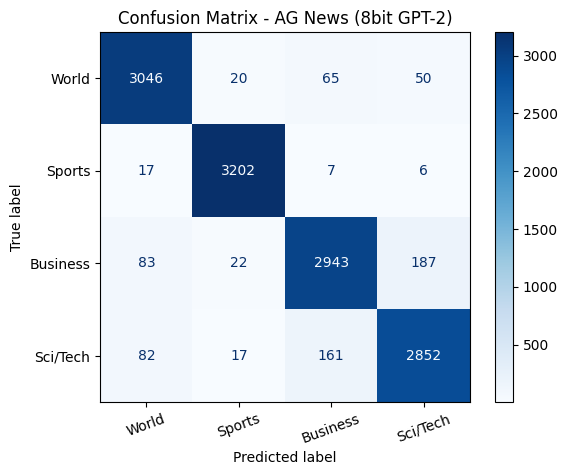


🔹 Evaluating 4bit quantized model...


Evaluating Batches: 100%|██████████| 798/798 [00:30<00:00, 26.12it/s]


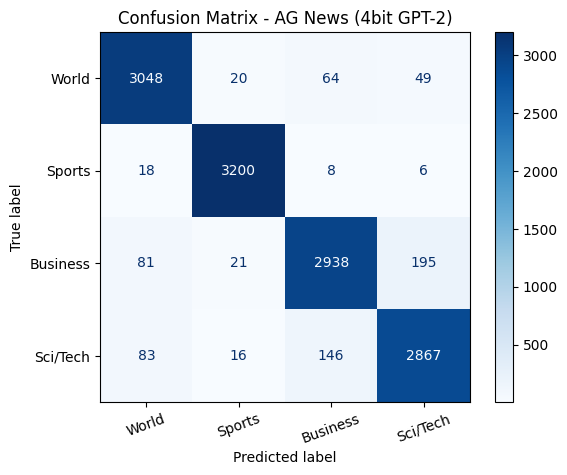

In [6]:
# ======================================
# 6. Model Quantization & Evaluation
# ======================================
from transformers import BitsAndBytesConfig

# Quantization configurations
quant_configs = {
    "8bit": BitsAndBytesConfig(
        load_in_8bit=True,
        llm_int8_threshold=6.0  # optional, controls INT8 quantization behavior
    ),
    "4bit": BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,  # computations in fp16
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"             # use NF4
    )
}

results = {}

for qname, qconfig in quant_configs.items():
    print(f"\n🔹 Evaluating {qname} quantized model...")

    model = GPT2ForSequenceClassification.from_pretrained(
        MODEL_DIR,
        device_map="auto",
        quantization_config=qconfig
    )

    metrics = evaluate_model(model, texts, labels, tokenizer, is_quantized=True)
    results[qname] = metrics


    # Confusion Matrix Visualization
    disp = ConfusionMatrixDisplay(
        confusion_matrix=metrics["confusion_matrix"],
        display_labels=["World", "Sports", "Business", "Sci/Tech"]
    )
    disp.plot(cmap="Blues", xticks_rotation=20)
    plt.title(f"Confusion Matrix - AG News ({qname} GPT-2)")
    plt.show()


In [ ]:
# ======================================
# 8. Print Results
# ======================================
for qname, metrics in results.items():
    print(f"\n📊 {qname.upper()} Quantized Model Metrics:")
    print(f"Accuracy : {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall   : {metrics['recall']:.4f}")
    print(f"F1-Score : {metrics['f1']:.4f}")
    print(f"Avg Latency: {metrics['latency_ms']:.2f} ms/sample")
    print(f"Memory Footprint: {metrics['memory_mb']:.2f} MB")


📊 8BIT Quantized Model Metrics:
Accuracy : 0.9438
Precision: 0.9436
Recall   : 0.9438
F1-Score : 0.9437
Avg Latency: 3.18 ms/sample
Memory Footprint: 156.36 MB

📊 4BIT Quantized Model Metrics:
Accuracy : 0.9446
Precision: 0.9444
Recall   : 0.9446
F1-Score : 0.9445
Avg Latency: 2.12 ms/sample
Memory Footprint: 115.86 MB


: 